In [1]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pylab as plt

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#variables + option
base_path = "/kaggle/input/prediction-interval-competition-ii-house-price/"
alpha = 0.1 

pd.set_option('display.max_columns', None)
sns.set_theme(style="dark")

"""
Note to self (100 - alpha*100) is the % prediction interval

for 0.1 it is 90% prediction interval
"""

/kaggle/input/prediction-interval-competition-ii-house-price/sample_submission.csv
/kaggle/input/prediction-interval-competition-ii-house-price/test.csv
/kaggle/input/prediction-interval-competition-ii-house-price/dataset.csv


'\nNote to self (100 - alpha*100) is the % prediction interval\n\nfor 0.1 it is 90% prediction interval\n'

## Winkler Score
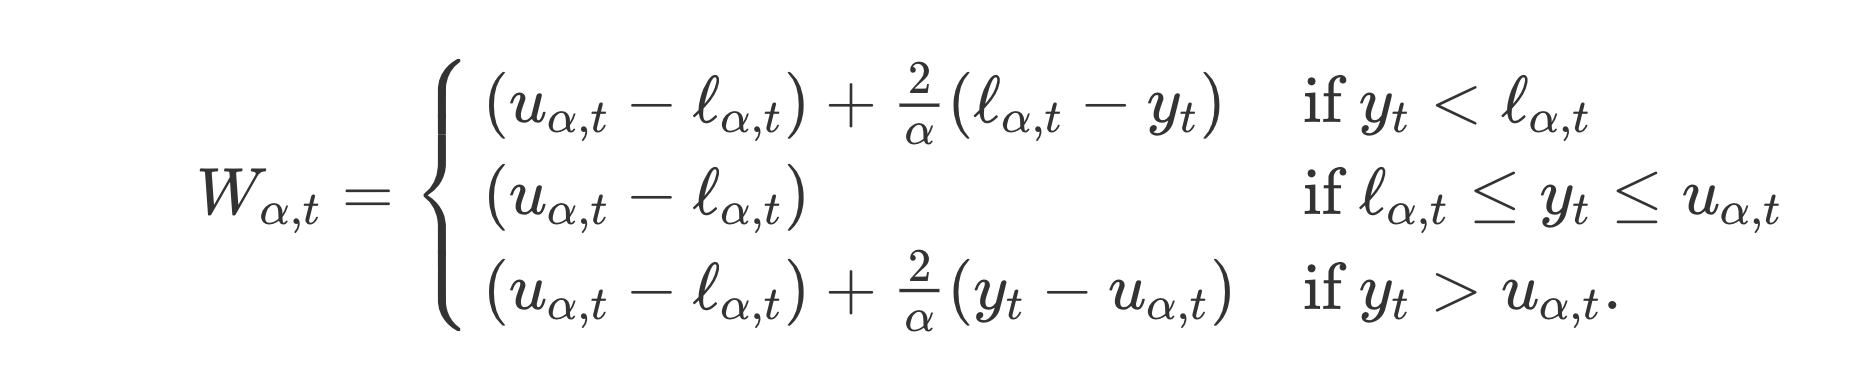

The first term (bounds subtracted) is the width of the interval and the second term in the first and last interval are penalites.

In [2]:
def wilson_score(upper, lower, y_true, alpha=0.1, return_coverage=False):

    upper = np.asarray(upper)
    lower = np.asarray(lower)
    y_true = np.asarray(y_true)

    interval_width = upper - lower

    penalty_lower = (2/alpha) * (lower - y_true)
    penalty_upper = (2/alpha) * (y_true - upper)

    score = interval_width.copy()
    score += np.where(y_true < lower, penalty_lower, 0)
    score += np.where(y_true > upper, penalty_upper, 0)

    if return_coverage:
        inside = (y_true >= lower) & (y_true <= upper)
        coverage = np.mean(inside)
        return np.mean(score), coverage

    return np.mean(score)

## EDA

Notes:
- Dropped two almost fully columns. Last one "submarket" needs to have averaged values in empty ones or some filler.
- Some cities have houses that sell for more than others.
- "rebuilt-before" is the join status with the highest sale_prices. Others are clustred bellow 1m.
- Submarkets play a role
- There are a lot of zones and woudn't use for traning as well as sale_warning.
- Can try testing having logs of diffrent columns like 'imp_value' and sale_price.
- Using a heatmap not much directly correlated w/ sale price.

In [3]:
df_train = pd.read_csv(base_path + "dataset.csv", index_col="id", parse_dates=["sale_date"]) # note extra options like index_col for future use
# df_test = pd.read_csv(base_path + "test.csv", index_col="id", parse_dates=["sale_date"])

#drop nan columns
df_train = df_train.drop(['subdivision', 'sale_nbr'], axis=1)
# df_test = df_test.drop(['submarket', 'subdivision', 'sale_nbr'], axis=1)

In [4]:
qualitative = list(df_train.columns[df_train.dtypes == "object"])

quantitative = list(df_train.columns[df_train.dtypes != "object"])
quantitative.pop(0)

'sale_date'

In [5]:
import warnings
warnings.filterwarnings("ignore")

sale_warning


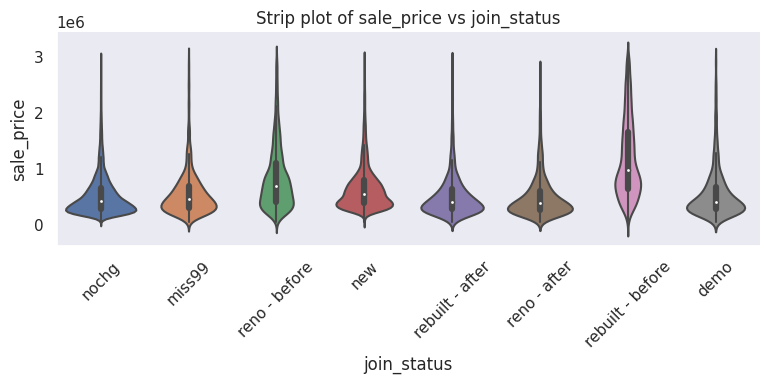

city
zoning


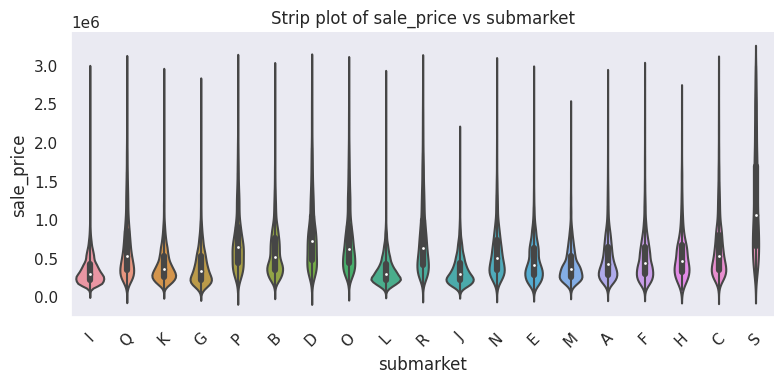

In [6]:
for col in qualitative:
    if df_train[col].nunique() <= 20:
        sns.catplot(x=col, y='sale_price', kind='violin', data=df_train, height=4, aspect=2)
        plt.xticks(rotation=45)
        plt.title(f'Strip plot of sale_price vs {col}')
        plt.tight_layout()
        plt.show()
    else: 
        print(col)

<Figure size 3000x1500 with 0 Axes>

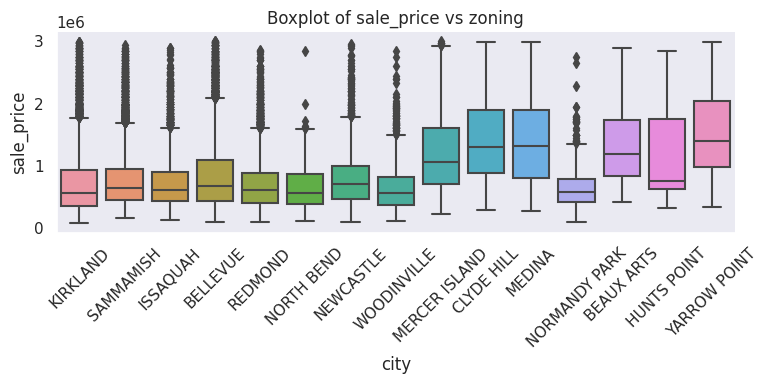

In [7]:
top_cities = df_train.groupby('city')['sale_price'].median().sort_values(ascending=False).head(15).index
filtered_df = df_train[df_train['city'].isin(top_cities)]

plt.figure(figsize=(30, 15)) 
sns.catplot(x='city', y='sale_price', kind='box', data=filtered_df, height=4, aspect=2)
plt.xticks(rotation=45)
plt.title('Boxplot of sale_price vs zoning')
plt.tight_layout()
plt.show()

In [8]:
df_train[quantitative] = df_train[quantitative].astype('float64')

In [9]:
df_corr = df_train[quantitative].dropna().corr()

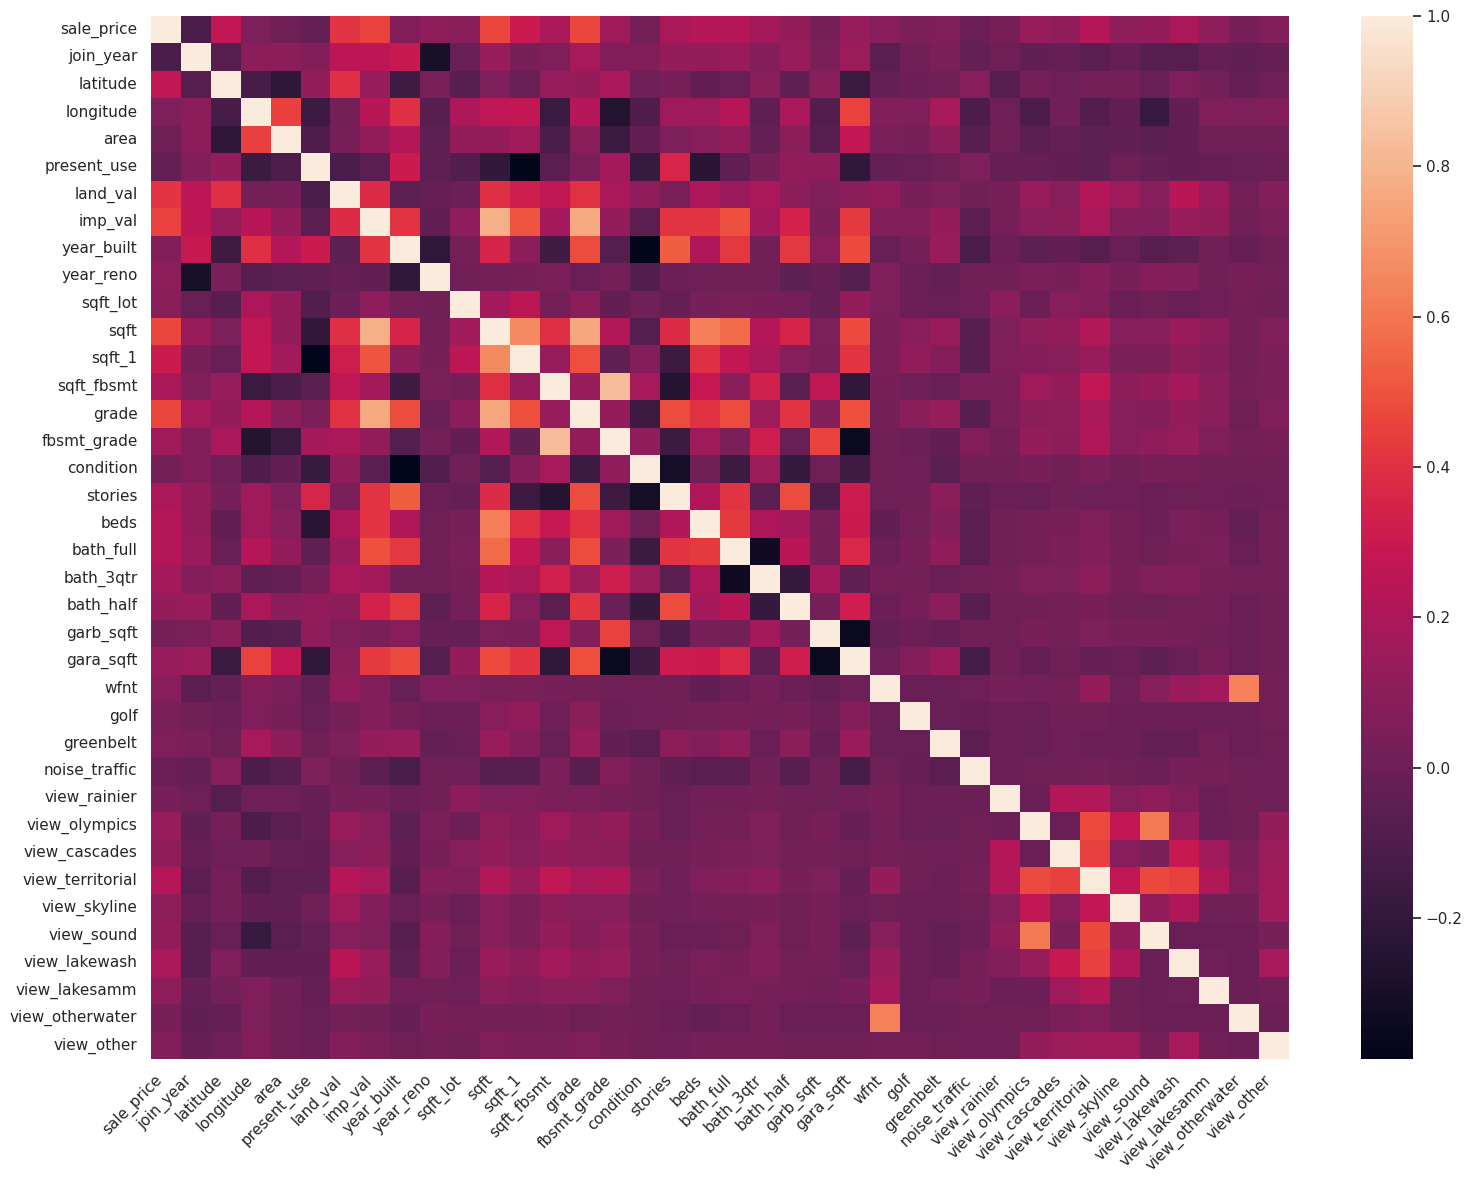

In [10]:
plt.figure(figsize=(16, 12))  #
sns.heatmap(df_corr, fmt=".1f")  
plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0)  
plt.tight_layout()  

<Axes: xlabel='imp_val', ylabel='Density'>

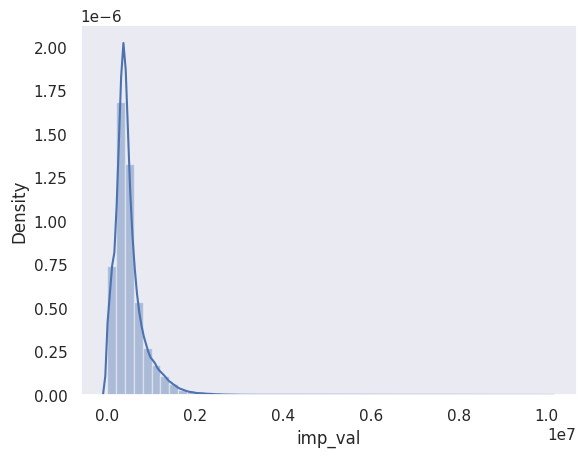

In [11]:
sns.distplot(df_train['imp_val'])

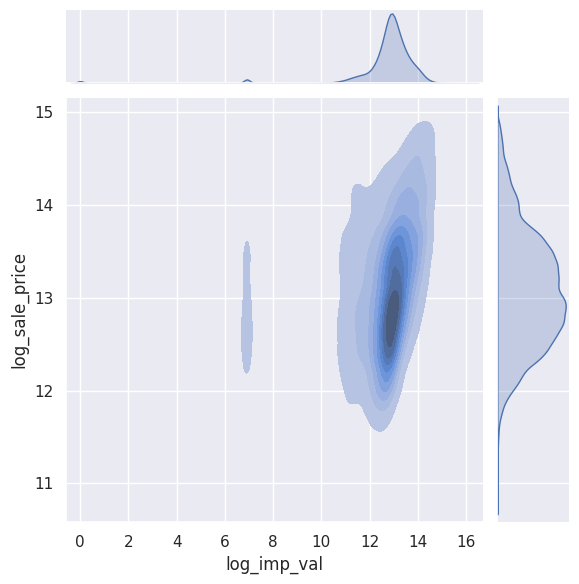

In [13]:
df_train['log_imp_val'] = np.log1p(df_train['imp_val'])  
df_train['log_sale_price'] = np.log1p(df_train['sale_price'])

sns.set(style="darkgrid")
sns.jointplot(x='log_imp_val', y='log_sale_price', kind='kde', data=df_train, fill=True)
plt.show()

## Modeling (Regression)

Start off with basic regression and move to desion trees. Note need to gen prediciton intervals

In [4]:
from sklearn import linear_model
import numpy as np

reg = linear_model.Lasso(alpha=0.1)

X = df_train[["sqft"]].values  
y = df_train["sale_price"].values  

reg.fit(X, y)

y_predict = reg.predict(df_test["sqft"].values.reshape(-1, 1))

In [ ]:
## use statsmodels summary fram to gen a predicon interval